# Imports

In [88]:
import ast
import numpy as np
import pandas as pd
import logging
import pennylane as qml
import autograd.numpy as anp
import matplotlib.pyplot as plt

from datetime import date

from tqdm import tqdm

from pennylane import numpy as np_qml

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.datasets import make_moons, make_blobs, make_circles

from sklearn.model_selection import KFold

seed = 42

np_qml.random.seed(seed)

In [104]:
import warnings

warnings.filterwarnings('ignore', message=".*Graph is not fully connected.*")

In [118]:
# Obter o logger raiz
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Define o nível mínimo de mensagens

# Remover todos os handlers existentes (se houver)
if logger.hasHandlers():
    logger.handlers.clear()

# Criar um FileHandler para salvar as mensagens em um arquivo
file_handler = logging.FileHandler(f'log_{date.today().strftime("%d_%m_%Y")}.log')
file_handler.setLevel(logging.DEBUG)

# Definir o formato das mensagens de log
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
file_handler.setFormatter(formatter)

# Adicionar o FileHandler ao logger
logger.addHandler(file_handler)


# VQC`s

## Circuit

In [80]:
dev = qml.device("lightning.gpu", wires=2)

def statepreparation(x):
    # qml.AmplitudeEmbedding(features=x, wires=range(2), pad_with=0)
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)

def apply_layer(W, layer_number):
    for i in range(len(W) // 2):
        qml.Rot(W[2 * i, 0], W[2 * i, 1], W[2 * i, 2], wires=0)
        qml.Rot(W[2 * i + 1, 0], W[2 * i + 1, 1], W[2 * i + 1, 2], wires=1)
        if i % 2 == 0:
            qml.CNOT(wires=[0, 1])
        else:
            qml.CNOT(wires=[1, 0]) if layer_number > 1 else qml.CNOT(wires=[0, 1])

def circuit(weights, X, layer_number):
    statepreparation(X)

    for W in weights:
        apply_layer(W, layer_number)

    return qml.expval(qml.PauliZ(wires=0))

def qvc_classifier(qnode, w, b, X):
    return qnode(w, X) + b

@qml.qnode(dev, interface="autograd")
def circuit_type1(weights, X):
    return circuit(weights, X, 1)

## Map Prediction

In [81]:
def map_prediction(pred):
    pred = np_qml.array(pred)
    pred = 2 / (1 + np_qml.exp(-pred)) - 1 # Coloca os valores para o intervalo de -1 a 1

    pred = np.array(list(map(lambda x: 1 if x >= 0 else -1, pred))) # Aplica o limitador para mapear os valores para 1 ou -1
    return pred

## Show Decision Region

In [82]:
def print_decision_region(X, qnode, x_max, y_max, weights, bias, predictions):
    plt.figure()
    cm = 'viridis'

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    features_grid = np.array(
        [x for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = [qvc_classifier(qnode, weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[-1, 1])

    # if predictions are provided, plot data points colored by predictions
    predictions = np.array(predictions)
    
    # Pinta os pontos baseados nas previsões
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=predictions,  # Usa as previsões para determinar as cores
        cmap='viridis',  # Mapa de cores para representar os valores contínuos de previsões
        marker="o",
        edgecolors="k"
    )

    plt.show()


## Cost Function

In [127]:
def cost(
        weights,
        bias, 
        qnode,
        features
    ):
    predictions = np_qml.array(
        [
            qvc_classifier(
                qnode,
                weights, 
                bias, 
                xi
            ) for xi in features
        ]
    )

    predictions = map_prediction(predictions)    

    if len(np.unique(predictions)) == 1: # Penaliza o circuito se tiver prevendo somente um cluster
        metric = np_qml.float16(1)
    else: 
        metric = 1 - silhouette_score(features, predictions)
    # l2 = 0.01 * (np_qml.sum(bias**2) + np_qml.sum(weights**2))
    
    return metric

## Train Function

In [84]:
# Função para calcular uma pontuação composta
# def calculate_composite_score(cost, silhouette, davies_bouldin, calinski_harabasz):
#     # Normalize as métricas (ajuste os pesos conforme necessário)
#     normalized_cost = 1 / (1 + cost)  # Quanto menor o custo, melhor
#     normalized_silhouette = silhouette  # Quanto maior, melhor
#     normalized_davies_bouldin = 1 / (1 + davies_bouldin)  # Quanto menor, melhor
#     normalized_calinski_harabasz = calinski_harabasz  # Quanto maior, melhor

#     # Combine as métricas (ajuste os pesos conforme necessário)
#     composite_score = (
#         0.3 * normalized_cost +
#         0.2 * normalized_silhouette +
#         0.2 * normalized_davies_bouldin +
#         0.1 * normalized_calinski_harabasz
#     )
#     return composite_score


def calculate_composite_score(
    cost, 
    silhouette, 
    davies_bouldin, 
    calinski_harabasz,
    min_cost, max_cost,
    min_silhouette, max_silhouette,
    min_davies, max_davies,
    min_calinski, max_calinski
):
    # Normalização min-max com tratamento para divisão por zero
    def normalize(value, min_val, max_val, reverse=False):
        if max_val == min_val:
            return 0.5  # Valor neutro se todos forem iguais
        if reverse:
            return (max_val - value) / (max_val - min_val)  # Quanto menor, melhor
        else:
            return (value - min_val) / (max_val - min_val)  # Quanto maior, melhor

    # Aplicar normalização
    norm_cost = normalize(cost, min_cost, max_cost, reverse=True)
    norm_silhouette = normalize(silhouette, min_silhouette, max_silhouette) if silhouette is not None else 0
    norm_davies = normalize(davies_bouldin, min_davies, max_davies, reverse=True) if davies_bouldin is not None else 0
    norm_calinski = normalize(calinski_harabasz, min_calinski, max_calinski) if calinski_harabasz is not None else 0

    # Calcular pontuação composta (ajuste os pesos)
    composite_score = (
        0.3 * norm_cost +
        0.3 * norm_silhouette +
        0.2 * norm_davies +
        0.2 * norm_calinski
    )
    return composite_score

In [128]:
def train_kfold(
    qnode, 
    features, 
    num_params_w_lines, 
    num_params_w_columns, 
    num_layers, 
    weight_init_max, 
    optimizer, 
    dic_optimizer, 
    seed, 
    iterations=100, 
    k=10,
    batch_size=32,
    show_log=False
):
    # Initialize k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    folders_metrics = []
    
    # Loop over folds
    for fold_idx, (train_index, val_index) in enumerate(kf.split(features)):
        X_train, X_val = features[train_index], features[val_index]

        all_costs = []  # To store cost values
        all_iterations = []

        # Initialize optimizer
        opt = optimizer(**dic_optimizer)
        
        # Initialize weights and bias
        # weights_init = weight_init_max * np.random.randn(num_layers, num_params_w_lines, num_params_w_columns)

        ## TESTE
        ### Utilizar uma distribuicao uniforme para inicializar os pesos
        weights_init = np_qml.random.uniform(-weight_init_max, weight_init_max, (num_layers, num_params_w_lines, num_params_w_columns), requires_grad=True)
        # Convert to a PyTorch tensor with requires_grad=True

        bias_init = np_qml.array(0.0, requires_grad=True)

        weights = weights_init
        bias = bias_init

        folder_infos = {
            "folder": fold_idx + 1,
            "best_weights": weights,
            "best_bias": bias,
            "best_cost": float('inf'),
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None
        }

        patience = 20
        no_improvement = 0

        # Training loop
        for it in range(iterations):
            # Mini-batch sampling

            # Mini-batch sampling (garanta que não exceda o tamanho do dataset)
            if batch_size > len(X_train):
                batch_size = len(X_train)

            batch_index = np.random.choice(len(X_train), batch_size, replace=False)
            X_train_batch = X_train[batch_index]

            # Train model on batch
            arguments = [weights, bias]
            (weights, bias), iteration_cost = opt.step_and_cost(lambda w, b: cost(w, b, qnode, X_train_batch), *arguments)

            # Update best weights and bias
            if iteration_cost < folder_infos['best_cost']:
                folder_infos['best_weights'] = weights
                folder_infos['best_bias'] = bias
                folder_infos['best_cost'] = iteration_cost

                no_improvement = 0
            else:
                no_improvement += 1
    
            all_costs.append(iteration_cost)
            all_iterations.append(it + 1)        

            logger.info(f"Fold: {fold_idx + 1} | Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {folder_infos['best_cost']:0.7f}")

            if no_improvement >= patience:
                break

        # Validation metrics
        predictions_val = [qvc_classifier(qnode, folder_infos['best_weights'], folder_infos['best_bias'], xi) for xi in X_val]
        predictions_val = map_prediction(predictions_val)
        
        if len(np.unique(predictions_val)) > 1:
            folder_infos['davies_bouldin'] = davies_bouldin_score(X_val, predictions_val)
            folder_infos['calinski_harabasz'] = calinski_harabasz_score(X_val, predictions_val)
            folder_infos['silhouette'] = silhouette_score(X_val, predictions_val)

        folders_metrics.append(folder_infos)

        # Plot cost evolution
        # if show_log:
        #     plt.plot(all_iterations, all_costs, label="Custo")
        #     plt.title(f"Evolução da Função de Custo (Fold {fold_idx + 1})")
        #     plt.xlabel("Iteração")
        #     plt.ylabel("Custo")
        #     plt.legend()
        #     plt.show()

        if show_log:
            # Definir o grau do polinômio (ex: 2 para quadrático, 3 para cúbico)
            grau_polinomio = 4  # Tente aumentar para 3 ou 4 se necessário

            # Ajuste polinomial
            coef = np.polyfit(all_iterations, all_costs, grau_polinomio)
            poly_eq = np.poly1d(coef)  # Criar a equação polinomial

            # Gerar valores da curva ajustada
            iter_range = np.linspace(min(all_iterations), max(all_iterations), 100)  # Mais pontos para suavizar a curva
            trend_line = poly_eq(iter_range)

            # Plotar os dados originais
            plt.plot(all_iterations, all_costs, label="Custo", marker="o", linestyle="-")

            # Plotar a curva polinomial ajustada
            plt.plot(iter_range, trend_line, label=f"Aproximação Polinomial (grau {grau_polinomio})", linestyle="--", color="red")

            # Configurações do gráfico
            plt.title(f"Evolução da Função de Custo (Fold {fold_idx + 1})")
            plt.xlabel("Iteração")
            plt.ylabel("Custo")
            plt.legend()
            plt.show()

    # Aplicar min-max scaling para normalizar as métricas
    all_costs = [f["best_cost"] for f in folders_metrics]
    all_silhouettes = [f["silhouette"] for f in folders_metrics if f["silhouette"] is not None]
    all_davies = [f["davies_bouldin"] for f in folders_metrics if f["davies_bouldin"] is not None]
    all_calinski = [f["calinski_harabasz"] for f in folders_metrics if f["calinski_harabasz"] is not None]

    min_cost, max_cost = min(all_costs), max(all_costs)
    min_sil, max_sil = min(all_silhouettes or [0]), max(all_silhouettes or [0])
    min_davies, max_davies = min(all_davies or [0]), max(all_davies or [0])
    min_cal, max_cal = min(all_calinski or [0]), max(all_calinski or [0])

    # Calcula a pontuação composta para cada fold
    for folder in folders_metrics:
        folder["composite_score"] = calculate_composite_score(
            folder["best_cost"],
            folder["silhouette"],
            folder["davies_bouldin"],
            folder["calinski_harabasz"],
            min_cost, max_cost,
            min_sil, max_sil,
            min_davies, max_davies,
            min_cal, max_cal
        )

    # Seleciona o melhor fold com base na pontuação composta
    best_folder = max(folders_metrics, key=lambda d: d["composite_score"])

    logger.info(f'A melhor Fold foi a {best_folder["folder"]}')
    logger.info(f'Custo: {best_folder["best_cost"]}')
    logger.info(f'Silhouette: {best_folder["silhouette"]}')
    logger.info(f'Davies Bouldin: {best_folder["davies_bouldin"]}')
    logger.info(f'Calinski Harabasz: {best_folder["calinski_harabasz"]}')
    logger.info(f'Pontuação Composta: {best_folder["composite_score"]}')

    # Plot decision region for best fold
    predictions = [qvc_classifier(qnode, best_folder['best_weights'], best_folder['best_bias'], xi) for xi in features]
    predictions = map_prediction(predictions)
    print_decision_region(features, qnode, x_max=np.pi, y_max=np.pi, weights=best_folder['best_weights'], bias=best_folder['best_bias'], predictions=predictions)

    return best_folder["best_cost"], best_folder["best_weights"], best_folder["best_bias"], best_folder["silhouette"], best_folder["davies_bouldin"], best_folder["calinski_harabasz"]

## Execute Function

In [130]:
def execute(
        X, 
        result_archive_name,
        iterations=100,
        batch_size=32,
        show_log=False
    ):
    # Definindo as combinações de otimizadores e circuitos a serem testados
    optimizers = {
        'SPSAOptimizer': SPSAOptimizer,
        # 'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
        # 'GradientDescentOptimizer': GradientDescentOptimizer,
    }

    circuits = [
        (circuit_type1, 2), 
        # (circuit_type2, 4),
        # (circuit_type3, 6), 
        # (circuit_type4, 6), 
        # (circuit_type5, 8)
    ]

    # Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
    optimizer_params = {
        'NesterovMomentumOptimizer': {'stepsize': 0.1, 'momentum': 0.9},
        'GradientDescentOptimizer': {'stepsize': 0.1},
        'SPSAOptimizer': {'maxiter': 100, 'alpha': 0.602, 'c': 0.101, 'gamma': 0.101}
    }

    # Parâmetros do experimento
    num_layers_options = [
        2, 
        # 4, 
        # 6, 
        # 8
    ]  # Escolher o número de camadas para o experimento

    log_results = []

    # Loop para experimentar combinações
    for circuit_fn, num_params_w_lines in circuits:
        for optimizer_name, optimizer_class in optimizers.items():
            for num_layers in num_layers_options:
                try:
                    logger.info(f"Testando: {circuit_fn.__name__} - {optimizer_name} - {num_layers} camadas")

                    # Instanciar o circuito e o QNode
                    circuit = circuit_fn
                    qnode = qml.QNode(circuit, dev, interface="torch")

                    # Treinamento com k-fold
                    cost, weights, bias, score_silhouette, score_davies, score_calinski = train_kfold(
                        qnode,
                        X,
                        num_params_w_lines=num_params_w_lines,
                        num_params_w_columns=3,
                        num_layers=num_layers,
                        weight_init_max=np.pi,
                        optimizer=optimizer_class,
                        dic_optimizer=optimizer_params[optimizer_name],
                        seed=seed,
                        iterations=iterations,
                        k=10,
                        batch_size=batch_size,
                        show_log=show_log
                    )

                    # Adicionar os resultados ao log
                    log_results.append({
                        'circuit_fn': circuit_fn.__name__,
                        'optimizer': optimizer_name,
                        'num_layers': num_layers,
                        'score_davies': score_davies,
                        'score_calinski': score_calinski,
                        'score_silhouette': score_silhouette,
                        'cost': cost,
                        'weights': weights.tolist(),  # Convertendo para lista, caso seja um array
                        'bias': bias, # Convertendo para lista, caso seja um array
                        'qnode': qnode
                    })

                except Exception as e:
                    logger.error(f"Erro ao testar {circuit_fn.__name__} - {optimizer_name} - {num_layers} camadas: {e}")
                    continue

    # Aplicar min-max scaling para normalizar as métricas
    all_costs = [f["cost"] for f in log_results]
    all_silhouettes = [f["score_silhouette"] for f in log_results if f["score_silhouette"] is not None]
    all_davies = [f["score_davies"] for f in log_results if f["score_davies"] is not None]
    all_calinski = [f["score_calinski"] for f in log_results if f["score_calinski"] is not None]

    min_cost, max_cost = min(all_costs), max(all_costs)
    min_sil, max_sil = min(all_silhouettes or [0]), max(all_silhouettes or [0])
    min_davies, max_davies = min(all_davies or [0]), max(all_davies or [0])
    min_cal, max_cal = min(all_calinski or [0]), max(all_calinski or [0])

    # Calcula a pontuação composta para cada fold
    for combination in log_results:
        combination["composite_score"] = calculate_composite_score(
            combination["cost"],
            combination["score_silhouette"],
            combination["score_davies"],
            combination["score_calinski"],
            min_cost, max_cost,
            min_sil, max_sil,
            min_davies, max_davies,
            min_cal, max_cal
        )

    # Seleciona o melhor fold com base na pontuação composta
    best_combination = max(log_results, key=lambda d: d["composite_score"])

    # Exibir os melhores parâmetros e resultados
    logger.info("\nMelhores Resultados:")
    logger.info(f"Otimizador: {best_combination['optimizer']}")
    logger.info(f"Tipo de Circuito: {best_combination['circuit_fn']}")
    logger.info(f"Número de Camadas: {best_combination['num_layers']}")
    logger.info(f"Custo: {best_combination['cost']}")
    logger.info(f"Score Davies: {best_combination['score_davies']}")
    logger.info(f"Score Calinski: {best_combination['score_calinski']}")
    logger.info(f"Score Silhouette: {best_combination['score_silhouette']}")

    # Salvar o log em um arquivo CSV
    log_df = pd.DataFrame(log_results)
    log_df.to_csv(f'{result_archive_name}.csv', index=False)

    # Visualizar a decisão do melhor modelo
    predictions = np.array(
        [
            qvc_classifier(
                best_combination['qnode'],
                best_combination['weights'], 
                best_combination['bias'], 
                xi
            ) for xi in X
        ]
    )

    predictions = map_prediction(predictions)

    print_decision_region(
        X, 
        best_combination['qnode'], 
        x_max=np.pi, 
        y_max=np.pi, 
        weights=best_combination['weights'], 
        bias=best_combination['bias'], 
        predictions=predictions
    )

# Datasets

## Utils

### Normalize

In [14]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled, y

## 2 Circles 2 Class

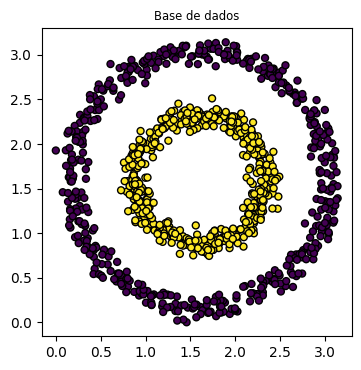

In [15]:
X, y = make_circles(
    (500, 500), factor=0.5, noise=0.05, random_state=seed
)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

### Execution

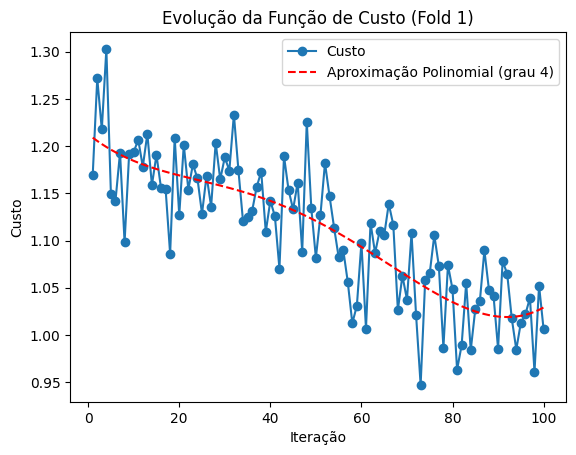

KeyboardInterrupt: 

In [124]:
execute(X, "circle", iterations=100, batch_size=64, show_log=True)

## 2 bubbles 2 class

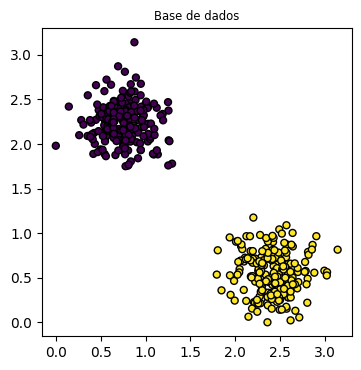

In [125]:
X, y = make_blobs(n_samples=400, centers=2, random_state=seed)

X, y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

### Execution

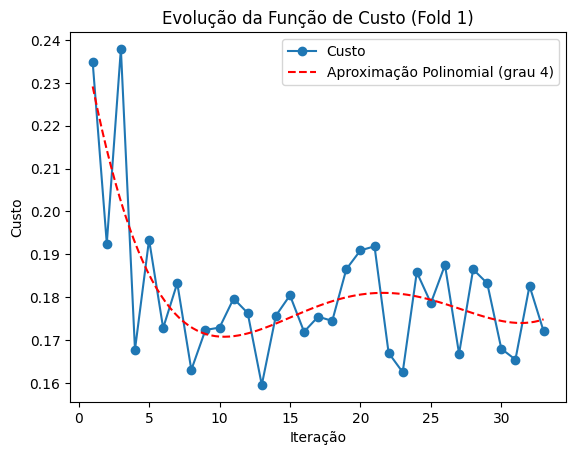

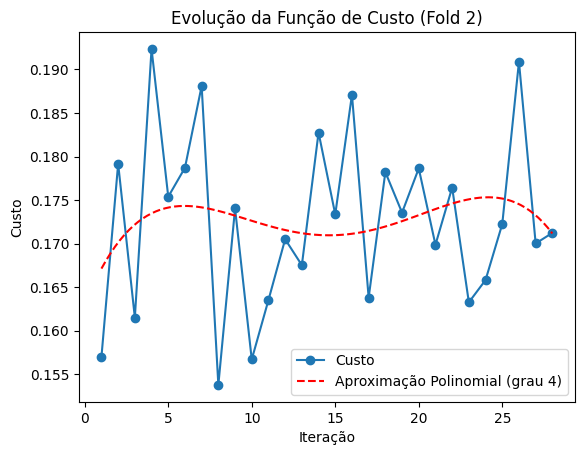

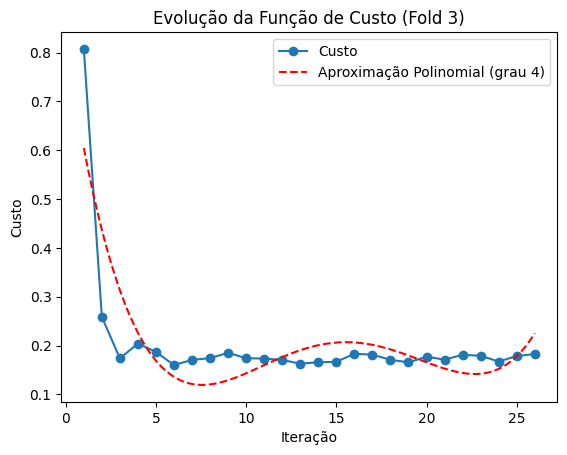

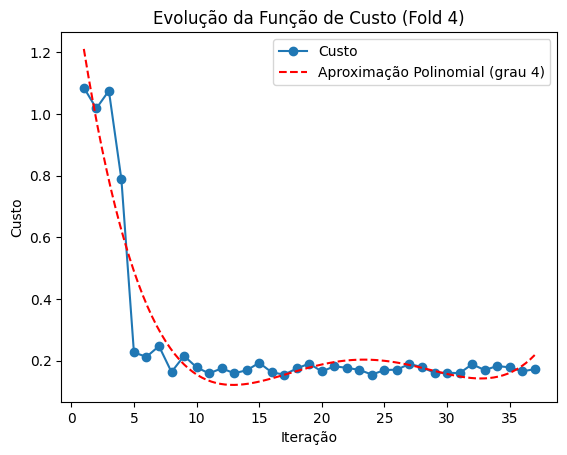

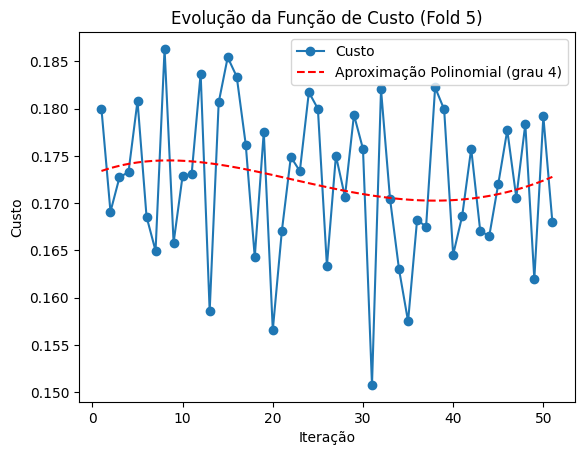

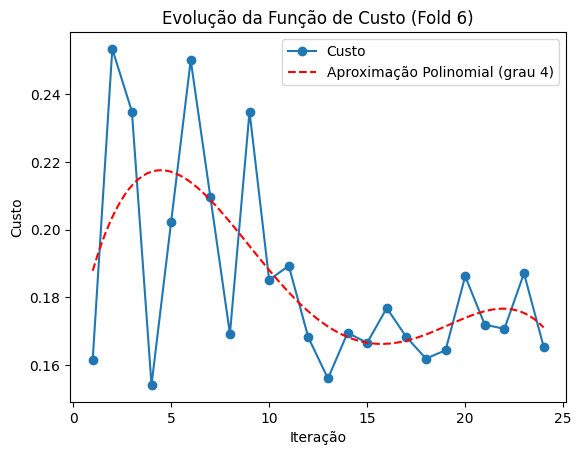

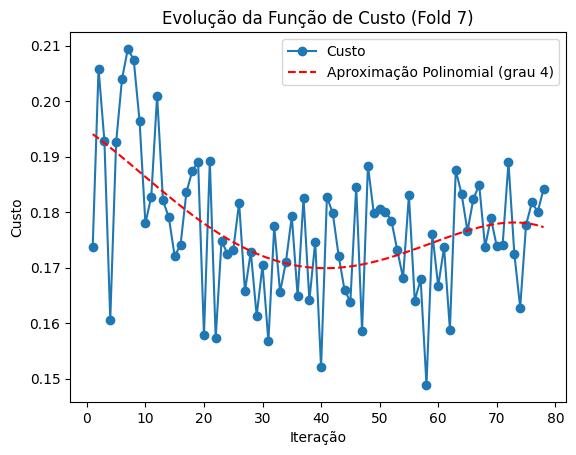

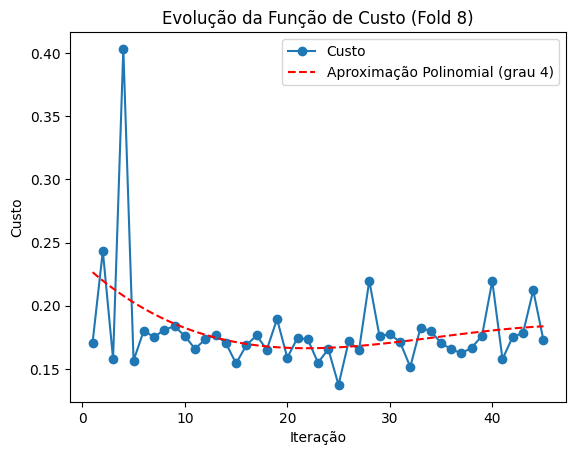

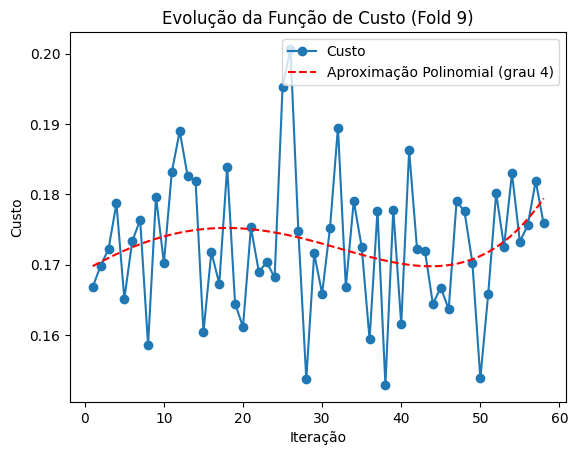

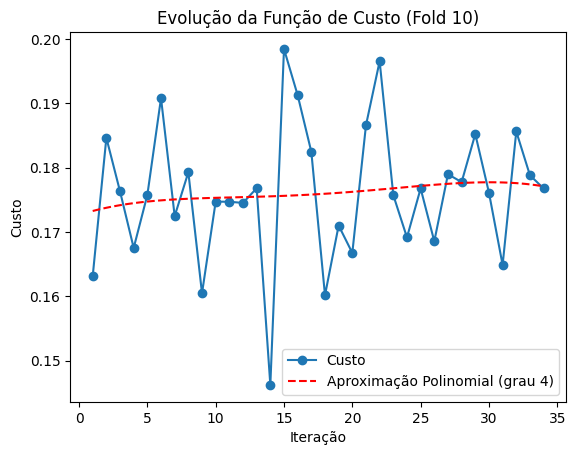

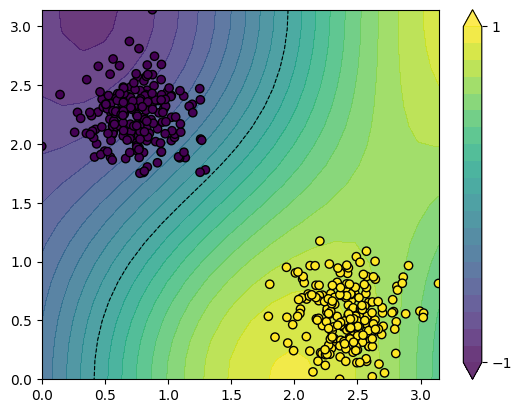

KeyError: 'qnode'

In [129]:
execute(X, "bubbles", iterations=100, batch_size=64, show_log=True)